# Basic example of data management and vectorization
Dataset: [climate-change-earth-surface-temperature-data](https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data?select=GlobalLandTemperaturesByMajorCity.csv)

In [1]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

In [2]:
from datetime import datetime

In [3]:
import geopandas

In [4]:
import matplotlib.pyplot as plt

In [5]:
dtypes = {
    'dt': lambda x: datetime.strptime(x, '%Y-%m-%d'),
    'Latitude': lambda x: float(x[:-1]) if x[-1] == 'N' else -1*float(x[:-1]),
    'Longitude': lambda x: float(x[:-1]) if x[-1] == 'E' else -1*float(x[:-1]),
}

In [6]:
D = pd.read_csv('https://island.ricerca.di.unimi.it/~alfio/shared/GlobalLandTemperaturesByMajorCity.csv', 
               converters=dtypes)
type(D.dt.values[0])

numpy.datetime64

In [7]:
dates = [x.astype('M8[D]').astype('O') for x in D.dt.values]
D['year'] = [x.year for x in dates]
D['month'] = [x.month for x in dates]
D['day'] = [x.day for x in dates]

In [8]:
T = D[(D.City=='Abidjan') & (D.dt > datetime(1900, 1, 1)) & (D.month == 1)]
time = T.dt.values
temp = T.AverageTemperature.values
inc = T.AverageTemperatureUncertainty.values

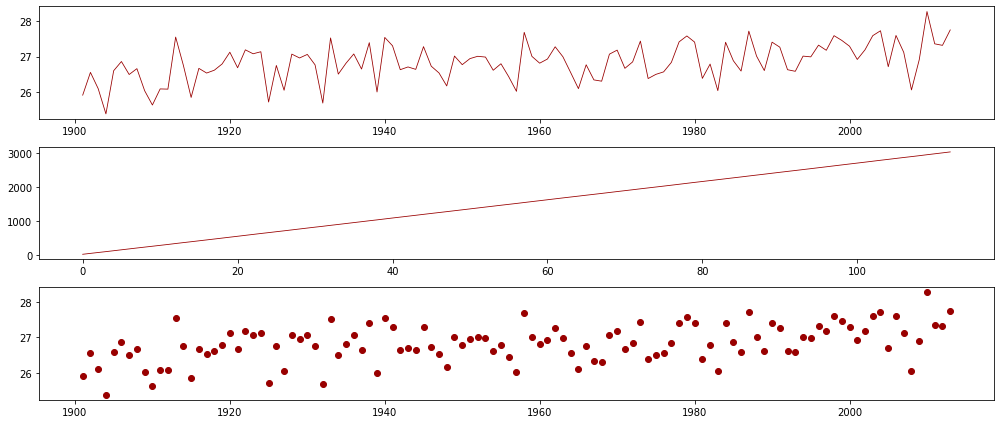

In [21]:
k = temp / temp.max()
fig, ax = plt.subplots(figsize=(14, 6), nrows=3)
ax[0].plot(time, temp, linewidth=0.8, c='#990000')
ax[1].plot(np.cumsum(temp), linewidth=0.8, c='#990000')
ax[2].scatter(time, temp, c='#990000')
plt.tight_layout()
plt.show()

## Exploit known data to make predictions
Linear regression
$$
\hat{y} = \theta_0 + \theta_1 x_1 + \dots + \theta_n x_n = \theta^T \cdot \mathbf{x}
$$
To train a model, we need to have a model (an initial set of $\theta$ values) and then minimize the error of the model, each time by updating the parameters. But how can we measure the error?
$$
MSE = \frac{1}{m} \sum\limits_{i = 1}^{m} \left (\theta_T \cdot \mathbf{x}^{(i)} - y^{(i)} \right ) ^2
$$

### Gradient descent
In order to get the direction and the slope of the changes in the cost function with respect to its parameters, we need to calculate how much the cost function will change if you change $\theta_j$. So, for each dimension in the parameters, we can compute the partial derivative of the cost function as:
$$
\frac{ \partial }{\partial \theta_j} MSE(\theta) = \frac{2}{m} \sum\limits_{i=1}{m} \left( \theta^T \cdot \mathbf{x}^{(i)} - y^{(i)} \right) x_{j}^{(i)}
$$
We call $\nabla_{\theta} MSE(\theta)$ the gradient vector.

### Learning
Depending on the direction of the gradient vector, we need to update the parameters in the opposite direction which leads to the gradient descent step, which size is determined by the learning rate $\eta$.
$$
\theta^{(step + 1)} = \theta - \eta \nabla_{\theta} MSE(\theta)
$$

In [108]:
X = ((np.array(range(len(time))) + 1) / 113).reshape(-1, 1)
y = temp.reshape(-1, 1)
X_b = np.c_[np.ones((113, 1)), X]

In [109]:
history = []
eta = 0.1
iterations = 1000
m = 100
theta = np.random.randn(2, 1)
for iteration in range(iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta * gradients
    history.append(theta)

In [112]:
def predict(new_x, theta):
    N = np.array((new_x + 1) / 113).reshape(-1, 1)
    N_b = np.c_[np.ones((N.shape[0], 1)), N]
    y_hat = N_b.dot(theta)
    return y_hat

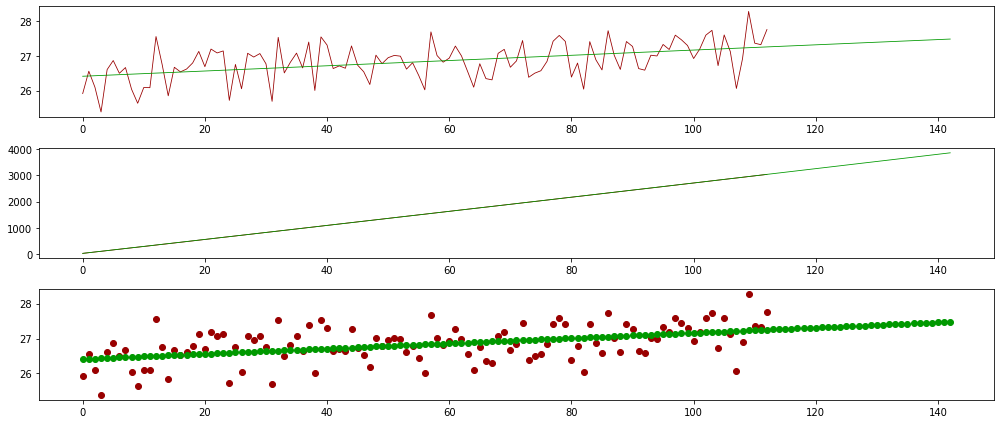

In [123]:
k = temp / temp.max()
e_time = np.array(range(len(time) + 30))
y_hat = predict(e_time, theta)
fig, ax = plt.subplots(figsize=(14, 6), nrows=3)
ax[0].plot(e_time[:-30], temp, linewidth=0.8, c='#990000')
ax[0].plot(e_time, y_hat, linewidth=0.8, c='#009900')
ax[1].plot(np.cumsum(temp), linewidth=0.8, c='#990000')
ax[1].plot(np.cumsum(y_hat), linewidth=0.8, c='#009900')
ax[2].scatter(e_time[:-30], temp, c='#990000')
ax[2].scatter(e_time, y_hat, c='#009900')
plt.tight_layout()
plt.show()

### During the training process

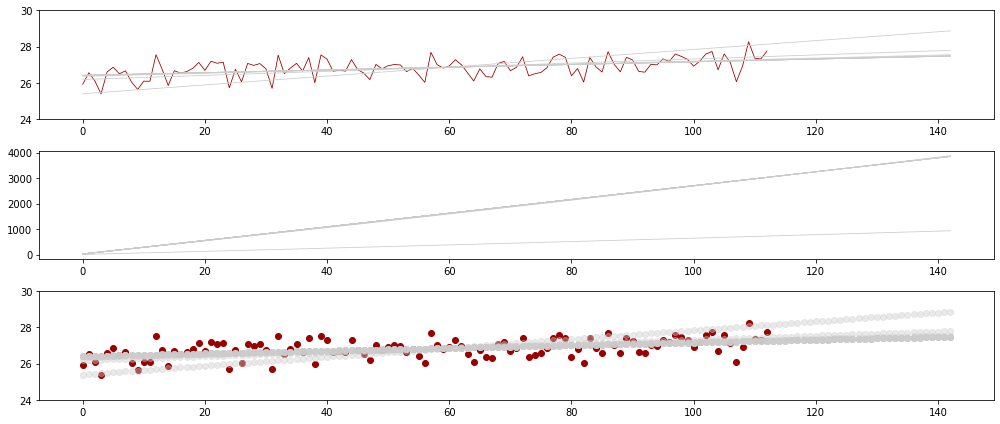

In [133]:
k = temp / temp.max()
e_time = np.array(range(len(time) + 30))
y_h = []
for i in range(0, 1000, 100):
    y_h.append(predict(e_time, history[i]))
fig, ax = plt.subplots(figsize=(14, 6), nrows=3)
ax[0].plot(e_time[:-30], temp, linewidth=0.8, c='#990000')
for h in y_h:
    ax[0].plot(e_time, h, linewidth=0.8, c='#cccccc')
ax[0].set_ylim(24, 30)
ax[1].plot(np.cumsum(temp), linewidth=0.8, c='#990000')
for h in y_h:
    ax[1].plot(np.cumsum(h), linewidth=0.8, c='#cccccc')
ax[2].scatter(e_time[:-30], temp, c='#990000')
for h in y_h:
    ax[2].scatter(e_time, h, c='#cccccc', alpha=0.4)
ax[2].set_ylim(24, 30)

plt.tight_layout()
plt.show()